# Setup

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
from typing import *
from collections import Counter


SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# Display the entire text
pd.set_option("display.max_colwidth", None)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
# For Colab
from google.colab import drive
drive.mount('/content/drive/')

curr_location = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/hw3/stud/"
os.chdir(curr_location)

In [3]:
curr_location = "H:/My Drive/Colab Notebooks/Deep Learning/NLP/nlp2022-hw3/hw3/stud"
os.chdir(curr_location)

This notebook contains all the relevant preprocessing part I have done.

It is organized in two parts:

1. The first part concerns a general analysis on the datasets.
2. The second part delves into the analysis of the Bert tokenized text.

# 1. Preprocessing

## Data Analysis

The `read_datset` function is taken from the `evaluate.py` file.

In [5]:
def read_dataset(path: str) -> List[Dict]:
    samples: List[Dict] = []
    pron_counter = Counter()
    with open(path) as f:
        next(f)
        for line in f:
            (
                id,
                text,
                pron,
                p_offset,
                entity_A,
                offset_A,
                is_coref_A,
                entity_B,
                offset_B,
                is_coref_B,
                url,
            ) = line.strip().split("\t")
            pron_counter[pron.lower()] += 1
            samples.append(
                {
                    "id": id,
                    "text": text,
                    "pron": pron,
                    "p_offset": int(p_offset),
                    "entity_A": entity_A,
                    "offset_A": int(offset_A),
                    "is_coref_A": is_coref_A,
                    "entity_B": entity_B,
                    "offset_B": int(offset_B),
                    "is_coref_B": is_coref_B,
                    "url": url,
                }
            )
    print(pron_counter)
    return samples, pron_counter

In [7]:
train_path = "../../model/data/train.tsv"
valid_path = "../../model/data/dev.tsv"

In [8]:
train_dataset, train_pron_counter = read_dataset(train_path)
valid_dataset, valid_pron_counter = read_dataset(valid_path)

Counter({'his': 904, 'her': 773, 'he': 610, 'she': 555, 'him': 157})
Counter({'her': 140, 'his': 108, 'he': 93, 'she': 87, 'him': 26})


In the **training** dataset there is a slightly **bias** towards the **male** pronouns (1671 M vs 1328 F).

In [11]:
train_gender_pron_counter = {
    "F": train_pron_counter['her'] + train_pron_counter['she'],
    "M": train_pron_counter['his'] + train_pron_counter['him'] + train_pron_counter['he']
}
train_gender_pron_counter

{'F': 1328, 'M': 1671}

The **validation** dataset is **perfectly balanced** between gender pronouns (227 pronous for both Female and Male).

In [13]:
valid_gender_pron_counter = {
    "F": valid_pron_counter['her'] + valid_pron_counter['she'],
    "M": valid_pron_counter['his'] + valid_pron_counter['him'] + valid_pron_counter['he']
}
valid_gender_pron_counter

{'F': 227, 'M': 227}

In [14]:
from matplotlib.pyplot import figure
def plot_freq(frequencies: dict, title: str = "plot"):
    """
    A bar chart with frequency of tokens.
    """
    figure(figsize=(8, 4), dpi=80)

    tokens = list(frequencies.keys())
    freq = list(frequencies.values())

    plt.bar(range(len(frequencies)), freq, tick_label=tokens)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

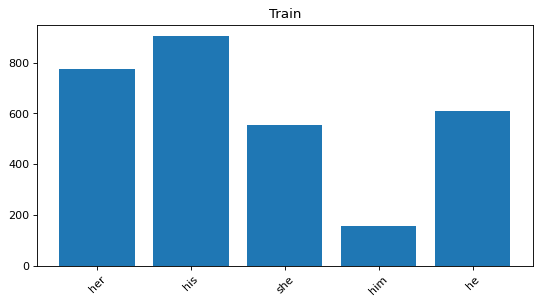

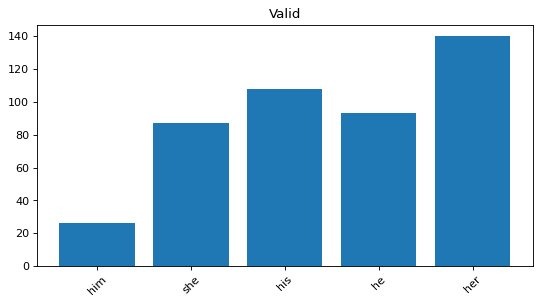

In [12]:
plot_freq(train_pron_counter, "Train")
plot_freq(valid_pron_counter, "Valid")

In [15]:
df_train = pd.DataFrame(train_dataset)
df_valid = pd.DataFrame(valid_dataset)

In [14]:
def freq_most_common_tokens(dataset_text: List[str], n: int = 20) -> dict:
    """
    Returns
    -------
        The first n common tokens and their frequencies, where the tokens are
        retrieved from the list 'dataset_text'.
        
    Parameters
    ----------
    dataset_text: List[str]
        A list of strings. In this case each string is a sentence.
    
    n: int
        Indicates how many tokens to consider.
        If it is a negative number, 
        the function returns the frequencies of all the tokens in the dataset.
    
    """

    # If negative number, return the frequency of all the tokens
    if n <= -1:
        return dict(Counter(dataset_text).most_common(len(Counter(dataset_text))))
    else:
        return dict(Counter(dataset_text).most_common(n))

In [15]:
freq_most_common_tokens(df_train['text'].tolist(),n=5)

{'According to her mother, Tatyana Vladimovna, Demkina was a fast learner, but was otherwise a normal child until she was ten years old, at which time her ability began to manifest itself.': 2,
 "Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.": 1,
 'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aest

In the **training** set there is a sentence containing two different ambiguous pronouns.

Indices 1900 and 1901.

In [16]:
for idx, sent in enumerate(df_train['text']):
    if sent == "According to her mother, Tatyana Vladimovna, Demkina was a fast learner, but was otherwise a normal child until she was ten years old, at which time her ability began to manifest itself.":
        print(idx)

1900
1901


In [17]:
df_train.iloc[1900]

id                                                                                                                                                                                            train-1901
text          According to her mother, Tatyana Vladimovna, Demkina was a fast learner, but was otherwise a normal child until she was ten years old, at which time her ability began to manifest itself.
pron                                                                                                                                                                                                 her
p_offset                                                                                                                                                                                              13
entity_A                                                                                                                                                                              Tatyana Vladim

In [18]:
df_train.iloc[1901]

id                                                                                                                                                                                            train-1902
text          According to her mother, Tatyana Vladimovna, Demkina was a fast learner, but was otherwise a normal child until she was ten years old, at which time her ability began to manifest itself.
pron                                                                                                                                                                                                 she
p_offset                                                                                                                                                                                             112
entity_A                                                                                                                                                                              Tatyana Vladim

In [19]:
all_train_text = ["".join(df_train['text'])]

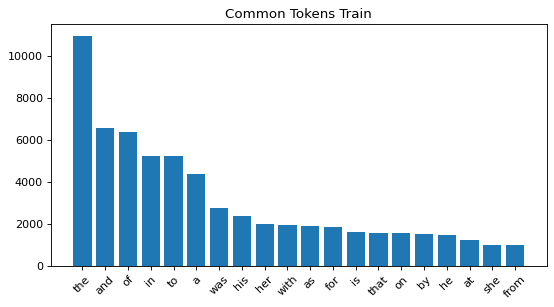

In [20]:
plot_freq(freq_most_common_tokens(all_train_text[0].split()), title="Common Tokens Train")

In [21]:
all_valid_text = ["".join(df_valid['text'])]

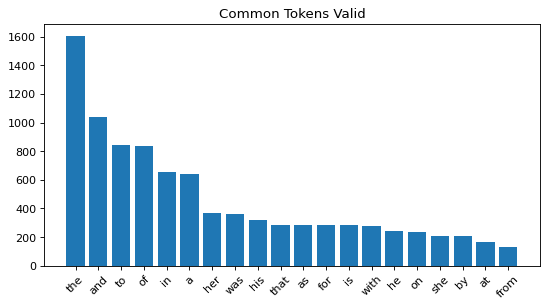

In [22]:
plot_freq(freq_most_common_tokens(all_valid_text[0].split()), title="Common Tokens Valid")

In [23]:
# Dataframe containing sentences where neither entities A nor B are the right entities coreferenced by the pronoun
df_train_neither_ent = df_train.loc[(df_train['is_coref_A'] == "FALSE") & (df_train['is_coref_B'] == "FALSE")]

df_train_A_ent = df_train.loc[df_train['is_coref_A'] == "TRUE"]
df_train_B_ent = df_train.loc[df_train['is_coref_B'] == "TRUE"]

print("# sentences:", df_train.shape[0])
print(f"# sentences neither: {df_train_neither_ent.shape[0]} ({((df_train_neither_ent.shape[0] / df_train.shape[0]) * 100):.2f}%)")
print(f"# sentences A: {df_train_A_ent.shape[0]} ({((df_train_A_ent.shape[0] / df_train.shape[0]) * 100):.2f}%)")
print(f"# sentences B: {df_train_B_ent.shape[0]} ({((df_train_B_ent.shape[0] / df_train.shape[0]) * 100):.2f}%)")

# sentences: 2999
# sentences neither: 315 (10.50%)
# sentences A: 1331 (44.38%)
# sentences B: 1353 (45.12%)


In [24]:
assert 2999 == 315+1331+1353

In [25]:
# Dataframe containing sentences where neither entities A nor B are the right entities coreferenced by the pronoun
df_valid_neither_ent = df_valid.loc[(df_valid['is_coref_A'] == "FALSE") & (df_valid['is_coref_B'] == "FALSE")]

df_valid_A_ent = df_valid.loc[df_valid['is_coref_A'] == "TRUE"]
df_valid_B_ent = df_valid.loc[df_valid['is_coref_B'] == "TRUE"]

print("# sentences:", df_valid.shape[0])
print(f"# sentences neither: {df_valid_neither_ent.shape[0]} ({((df_valid_neither_ent.shape[0] / df_valid.shape[0]) * 100):.2f}%)")
print(f"# sentences A: {df_valid_A_ent.shape[0]} ({((df_valid_A_ent.shape[0] / df_valid.shape[0]) * 100):.2f}%)")
print(f"# sentences B: {df_valid_B_ent.shape[0]} ({((df_valid_B_ent.shape[0] / df_valid.shape[0]) * 100):.2f}%)")

# sentences: 454
# sentences neither: 62 (13.66%)
# sentences A: 187 (41.19%)
# sentences B: 205 (45.15%)


In [26]:
assert 454 == 62+187+205

The datasets are pretty balanced with respect to the A and B entities; but we have fewer examples of "neither".

### How many sentences have the entity mention after the pronoun?

In [27]:
def get_coreferent_entity_offset(row: Union[dict, pd.Series]) -> int:
    """
    Returns
    -------
        The offset of the enitity coreferenced by the pronoun;
        or -1 if the pronoun does not refer to any of the 
        two mentions.

    Parameters
    ----------
    row: Union[dict, pd.Series]
        A dictionary or a pandas Series containing
        information about enitities offset positions
        and whether they are coreferenced by the pronoun. 
    """

    not_coref_A = row["is_coref_A"] in ["FALSE", "False", False]
    not_coref_B = row["is_coref_B"] in ["FALSE", "False", False]
    if not_coref_A and not_coref_B:
        return -1
    is_coref_A = row["is_coref_A"] in ["TRUE", "True", True]
    return row["offset_A"] if is_coref_A else row["offset_B"]

In [28]:
def count_entity_after_pronoun(dataset: List[Dict]):
    count_entity_after = 0
    for row in dataset:
        offset = get_coreferent_entity_offset(row)
        p_offset = row['p_offset']

        if offset > p_offset:
            count_entity_after += 1

    return count_entity_after

In [29]:
num_entity_after_pronoun_train = count_entity_after_pronoun(train_dataset)
print(f"Number of entities after the pronoun in training set: {num_entity_after_pronoun_train} ({((num_entity_after_pronoun_train / len(train_dataset)) * 100):.2f}%)")
num_entity_after_pronoun_valid = count_entity_after_pronoun(valid_dataset)
print(f"Number of entities after the pronoun in validation set: {num_entity_after_pronoun_valid} ({((num_entity_after_pronoun_valid / len(valid_dataset)) * 100):.2f}%)")

Number of entities after the pronoun in training set: 537 (17.91%)
Number of entities after the pronoun in validation set: 80 (17.62%)


As we can see, a good percentage of sentences have the coreferenced entity after the ambiguous pronoun.

### Which is the distance between the mentions and the pronoun?

In [30]:
def print_distance_ent_pront(df: pd.DataFrame):
    print(f"Minimum distance from A: {df['distance_A'].min()}")
    print(f"Maximum distance from A: {df['distance_A'].max()}")
    print(f"Average distance from A: {df['distance_A'].mean():.1f}")
    print()
    print(f"Minimum distance from B: {df['distance_B'].min()}")
    print(f"Maximum distance from B: {df['distance_B'].max()}")
    print(f"Average distance from B: {df['distance_B'].mean():.1f}")

In [31]:
df_train['distance_A'] = abs(df_train['p_offset'] - df_train['offset_A'])
df_train['distance_B'] = abs(df_train['p_offset'] - df_train['offset_B'])

In [32]:
print_distance_ent_pront(df_train)

Minimum distance from A: 4
Maximum distance from A: 577
Average distance from A: 95.3

Minimum distance from B: 4
Maximum distance from B: 461
Average distance from B: 58.3


In [33]:
df_valid['distance_A'] = abs(df_valid['p_offset'] - df_valid['offset_A'])
df_valid['distance_B'] = abs(df_valid['p_offset'] - df_valid['offset_B'])

In [34]:
print_distance_ent_pront(df_valid)

Minimum distance from A: 5
Maximum distance from A: 580
Average distance from A: 89.2

Minimum distance from B: 4
Maximum distance from B: 396
Average distance from B: 52.9


Perhaps the distance analysis may be useful if applied to the tokenized text, as we can consider the distance between tokens and not characters.

In [35]:
def print_text_length(df: pd.DataFrame):
    df_text_lens = df['text'].map(lambda sentence: len(sentence))

    print("Sentences length in dataframe:")
    print(f"Mean length: {df_text_lens.mean():.2f}")
    print(f"Min length: {df_text_lens.min():.2f}")
    print(f"Max length: {df_text_lens.max():.2f}")

In [36]:
print_text_length(df_train)

Sentences length in dataframe:
Mean length: 430.92
Min length: 69.00
Max length: 1347.00


In [37]:
print_text_length(df_valid)

Sentences length in dataframe:
Mean length: 426.39
Min length: 147.00
Max length: 1012.00


## Data Cleaning

I want to check if there are special characters in the datasets.

In [38]:
special_symbols = ["؛", "۔", "،", "。", "؟", "।", "、", 
                    "，", "¡", "¿", "…", "‡","×", "†", 
                    "√", "·", "→", "«", "»", "™", "′", 
                    "•", "„", "½", "¼", "¾", "∞", "θ",
                    "∅", "²", "³"]
currencies = ['£', '€', '¥', '฿', '₽', '﷼', '₴', '₠', '₡', '₢', '₣', '₤', '₥', '₦', '₧', '₨', '₩', '₪', '₫', '€', '₭', '₮', '₯', '₰', '₱', '₲', '₳', '₴', '₵', '₶', '₷', '₸', '₹', '₺', '₻', '₼', '₽', '₾', '₿']
dashes = ['–', "―", "—"]
quotes = ["‘","’", "“", "”", "„", "\""]

special_characters = special_symbols + currencies + dashes + quotes

In [39]:
def check_for_special_char(text: str) -> bool:
    """
    Returns
    -------
        True if a special_character is in text;
        False otherwise.
    """
    for c in special_characters:
        if c in text:
            print(c)
            return True
    return False

In [40]:
special_in_train = df_train['text'].map(check_for_special_char)
special_in_valid = df_valid['text'].map(check_for_special_char)

In [41]:
if any(special_in_train):
    print("There are special characters in the training set.")
if any(special_in_valid):
    print("There are special characters in the validation set.")

After the check I can say that the datasets are pretty cleaned.

In [42]:
df_train.sample(5)

,id,text,pron,p_offset,entity_A,offset_A,is_coref_A,entity_B,offset_B,is_coref_B,url,distance_A,distance_B
1779,train-1780,"Jeanine Basinger (born 3 February 1936), a film historian, is Corwin-Fuller Professor of Film Studies and Founder and Curator of The Cinema Archives at Wesleyan University, Middletown, Connecticut. She is also a Trustee of the American Film Institute (which awarded her an honorary degree, a Doctorate of Humane Letters, on June 7, 2006 ), a member of the Steering Committee of the National Center for Film and Video Preservation, and one of the Board of Advisors for the Association of Independent Video and Filmmakers.",She,198,Jeanine Basinger,0,TRUE,Trustee,212,FALSE,http://en.wikipedia.org/wiki/Jeanine_Basinger,198,14
341,train-342,"Heather O'Rourke (December 27, 1975 -- February 1, 1988) was an American child actress who played Carol Anne Freeling in the Poltergeist film trilogy and made several television guest appearance s. O'Rourke died due to medical error, and her death had long-lasting effects on her family and the media industry.",her,238,Carol Anne Freeling,98,FALSE,O'Rourke,198,TRUE,http://en.wikipedia.org/wiki/Heather_O'Rourke,140,40
1276,train-1277,"George Sherwood Hume, (March 1, 1893 -- 1979) was a Canadian geologist. Born in Milton West, Ontario, Hume was a graduate of the University of Toronto. After serving in World War I, he received a Ph.D. from Yale University in 1920.",he,182,Milton West,80,FALSE,Hume,102,TRUE,http://en.wikipedia.org/wiki/George_Sherwood_Hume,102,80
1012,train-1013,"On June 13 she hosted with Raul Gracia, Felipe Viel, Elizabeth Lopez and Carolina La O, Bienvenido el Mundial (Welcome to the World Cup), welcoming the FIFA World Cup. On June 28 in North Carolina, Sandoval received an award for being the boldest host. On July 12, she was a host on the memorial special for Michael Jackson.",she,265,Elizabeth Lopez,53,FALSE,Carolina La O,73,FALSE,http://en.wikipedia.org/wiki/Carolina_Sandoval,212,192
470,train-471,"In addition, her father was the first head of their church's credit union, which helped the parishioners with small loans. Polly has two sisters: Fernie, now a retired Dean from the University of Colorado, and Bettie Baca, a consultant in Washington, DC. Her great-grandfather helped found Trinidad, Colorado.",Her,255,Polly,123,TRUE,Bettie Baca,210,FALSE,http://en.wikipedia.org/wiki/Polly_Baca,132,45


The only thing I noticed is the presence of the backtick **\`** in some parts of the text: it opens a quotation but it doesn't close it. Therefore, I decided to replace the backtick with a single quote **'**.

In [43]:
def clean_text(text):
    text = text.translate(str.maketrans("`", "'"))
    return text

In [44]:
def clean_dataframe(df):
    df['text'] = df['text'].map(clean_text)
    df['entity_A'] = df['entity_A'].map(clean_text) 
    df['entity_B'] = df['entity_B'].map(clean_text) 

In [45]:
clean_dataframe(df_train)
clean_dataframe(df_valid)

Save the cleaned datasets to disk, so they can be directly loaded during training.

    train_clean_path = "../../model/data/train_clean.tsv"
    valid_clean_path = "../../model/data/valid_clean.tsv"
    df_train.to_csv(path_or_buf=train_clean_path, sep="\t", index=False)
    df_valid.to_csv(path_or_buf=valid_clean_path, sep="\t", index=False)

# 2. Data Analysis on Tokenized Text

In [1]:
from transformers import (
    AutoTokenizer,
    BertModel,
    logging
)
logging.set_verbosity_error()

In [4]:
train_clean_path = "../../model/data/train_clean.tsv"
valid_clean_path = "../../model/data/valid_clean.tsv"

df_train = pd.read_csv(filepath_or_buffer=train_clean_path, sep="\t")
df_valid = pd.read_csv(filepath_or_buffer=valid_clean_path, sep="\t")

For simplicity I will use the Bert `base-uncased` tokenizer.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [49]:
def print_tokenized_text_length(df: pd.DataFrame):
    df_text_lens = df['text'].map(lambda sentence: len(tokenizer.tokenize(sentence)))

    print("Tokenized sentences length in dataframe:")
    print(f"Mean length: {df_text_lens.mean():.2f}")
    print(f"Min length: {df_text_lens.min():.2f}")
    print(f"Max length: {df_text_lens.max():.2f}")

In [50]:
print_tokenized_text_length(df_train)

Tokenized sentences length in dataframe:
Mean length: 96.01
Min length: 13.00
Max length: 353.00


In [51]:
print_tokenized_text_length(df_valid)

Tokenized sentences length in dataframe:
Mean length: 94.88
Min length: 35.00
Max length: 226.00


Since the maximum lenght of the tokenized sentences is less than 512, I should not have problem with bert models. This because the maximum sequence length accepted by a Bert model is 512.

In [52]:
print(f"Tokenizer vacabulary length: {len(tokenizer.vocab)}")

Tokenizer vacabulary length: 30522


In [53]:
tokenizer.add_tokens(["<a>", "</a>", "<b>", "</b>", "<p>"], special_tokens=True)

5

In the training part, it may happen that I need to insert some special tokens in the sentences, therefore the vocabulary size of the tokenizer increases.

This may be problematic if the vocabulary size is not compliant with the embedding size of the transformer model. For solving this issue I have to resize the embedding size using the huggingface method `resize_token_embeddings`.

In [54]:
print(f"Tokenizer vacabulary length: {len(tokenizer.vocab)}")

Tokenizer vacabulary length: 30527


In [55]:
bert_model_name = "bert-base-uncased"
bert = BertModel.from_pretrained(bert_model_name).to(device, non_blocking=True)

In [56]:
bert.embeddings.word_embeddings

Embedding(30522, 768, padding_idx=0)

In [57]:
bert.config.vocab_size != len(tokenizer.vocab)

True

In [58]:
bert.resize_token_embeddings(len(tokenizer.vocab))

Embedding(30527, 768)

In [59]:
bert.embeddings.word_embeddings

Embedding(30527, 768)

In [60]:
bert.config.vocab_size == len(tokenizer.vocab)

True